In [74]:
# Data Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modelling
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import seaborn as sns; sns.set()

In [75]:
import imblearn
from imblearn import under_sampling, over_sampling
from imblearn.ensemble import BalancedRandomForestClassifier

# 18var

In [76]:
df_18 = pd.read_csv('https://raw.githubusercontent.com/flinksey/CDC_BRFSS/refs/heads/main/2023-brfss-18var.csv')
df_18.head()

,Had_Stroke,Depression,GenHealth,PhysHealth,MentalHealth,withHealthInsur,Exercise150,Hi_BP,Hi_Cholesterol,Chronic_Heart,Race,Sex,Age,Hi_BMI,Education,Income,Smoker,Drinker,Diabetes
0,0,1,0,1,1,1,1,1,0,0,1,0,6,1,3,5,4,0,1
1,0,0,1,0,1,1,0,1,1,0,2,0,6,1,3,4,4,0,0
2,0,0,1,1,1,1,1,1,1,1,1,1,6,0,2,5,3,0,1
3,0,0,1,1,1,1,1,1,1,0,1,1,5,1,3,5,4,0,0
4,0,0,1,1,1,1,1,0,0,0,1,0,6,1,4,6,3,0,0


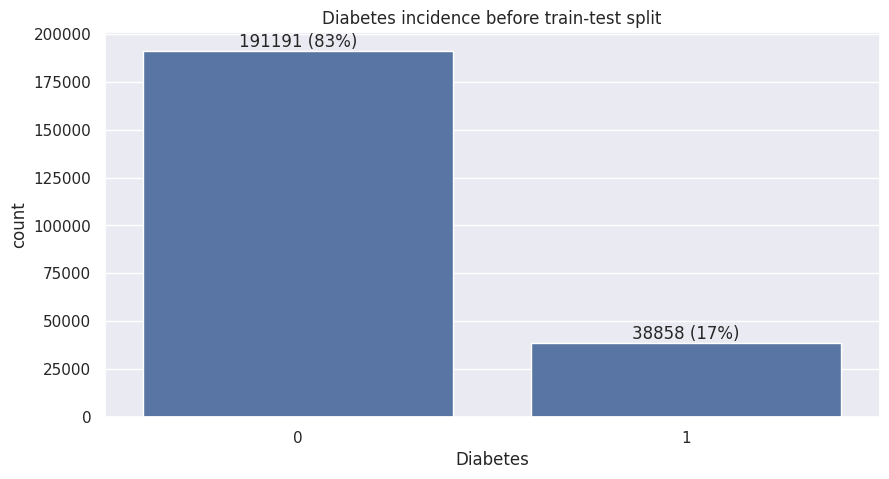

In [77]:
# check initial diabetes class split
fig_18, ax_18 = plt.subplots(figsize=(10,5))
ax_18 = sns.countplot(x='Diabetes', data=df_18, order=df_18['Diabetes'].value_counts().index)

abs_18 = df_18['Diabetes'].value_counts().values # get the count of samples for every Diabetes label
rel_18 = df_18['Diabetes'].value_counts(normalize=True).values*100 # get the percentage of samples with each Diabetes label

# include the count and percentage info in the plot
labs_18 = [f'{i[0]} ({i[1]:.0f}%)' for i in zip(abs_18, rel_18)]
ax_18.bar_label(container=ax_18.containers[0], labels=labs_18)

ax_18.set_title("Diabetes incidence before train-test split")
fig_18.show()

## 18var base

No class balancing, no model customization

In [78]:
# split the features and the target
y_18 = df_18['Diabetes']
X_18 = df_18.drop('Diabetes', axis=1) # keep all columns except that of the target, Diabetes

# split the features and target into the train and test datasets
X_train_18, X_test_18, y_train_18, y_test_18 = train_test_split(X_18, y_18, random_state=24, stratify=y_18) # random_state to ensure reproducibility, stratify to ensure we have same proportion of the class in the split vs original dataset

In [79]:
# create instance of the base generic RF
# just want to create basis model so I'll keep the default values
rf_18 = RandomForestClassifier(random_state=18)
rf_18.fit(X_train_18, y_train_18) # fit the base model

RandomForestClassifier(random_state=18)

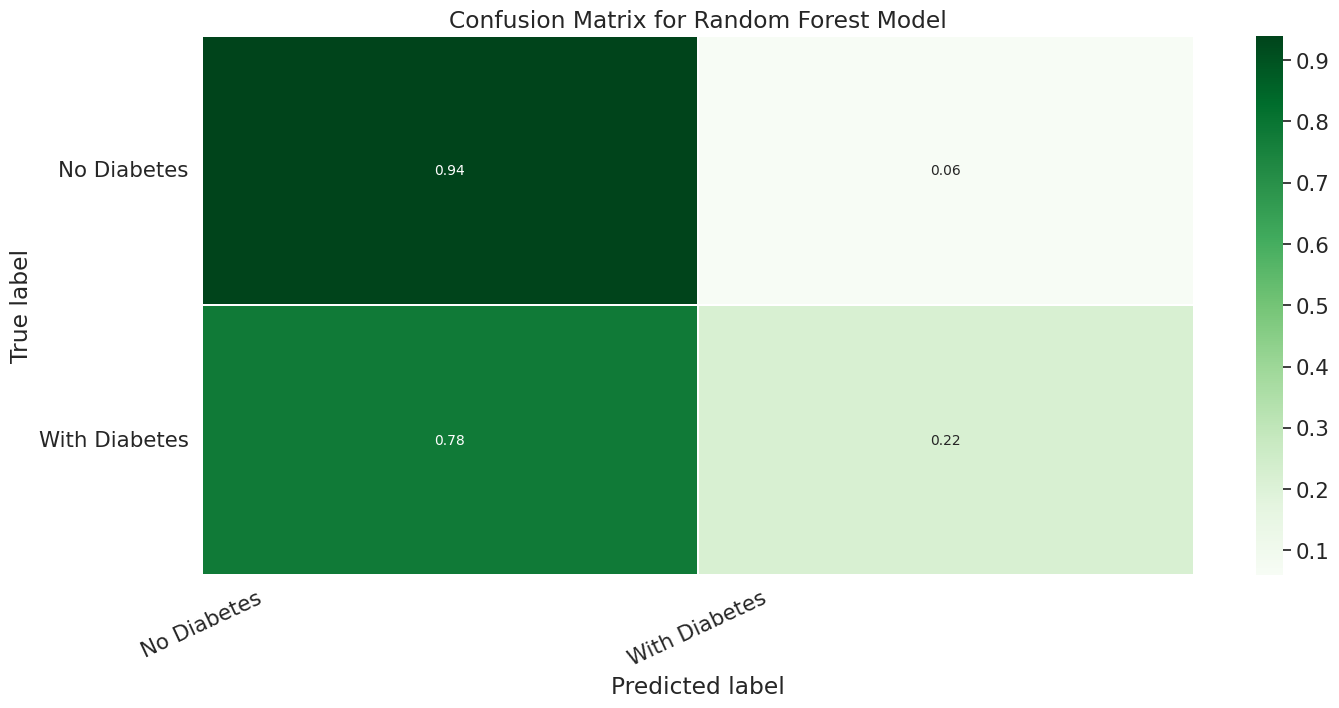

In [80]:
# make predictions on the test set
pred_18 = rf_18.predict(X_test_18)

# print the confusion matrix using Seaborn heatmap()
# Get and reshape confusion matrix data
m_18 = confusion_matrix(y_test_18, pred_18)
m_18 = m_18.astype('float') / m_18.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(m_18, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['No Diabetes', 'With Diabetes']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [81]:
print(classification_report(y_test_18,pred_18))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     47798
           1       0.43      0.22      0.29      9715

    accuracy                           0.82     57513
   macro avg       0.64      0.58      0.59     57513
weighted avg       0.78      0.82      0.79     57513



Downsampling + class_weight='balanced'

In [82]:
from sklearn.utils import resample

In [83]:
# downsampling
# our majority class here is class 0
X_d18, y_d18 = resample(X_train_18[y_train_18 == 0],
                      y_train_18[y_train_18 == 0],
                      replace=False, # no need to sample with replacement because we do have at least 100k majority case samples
                      n_samples=np.sum(y_train_18 == 1), # we sample majority class to match the number of samples in the minority class
                      random_state=24) # setting random state to make this reproducible

# Concatenate the downsampled data with the minority class data

X_balcon_18 = [X_d18, X_train_18[y_train_18 == 1]] # type DataFrame
y_balcon_18 = [y_d18, y_train_18[y_train_18 == 1]] # type Series

X_bal18 = pd.concat(X_balcon_18)
y_bal18 = pd.concat(y_balcon_18)

In [84]:
# create instance of the base generic RF
# just want to create basis model so I'll keep the default values
rf_bal18 = RandomForestClassifier(class_weight='balanced',random_state=19)
rf_bal18.fit(X_bal18, y_bal18) # fit the base model

RandomForestClassifier(class_weight='balanced', random_state=19)

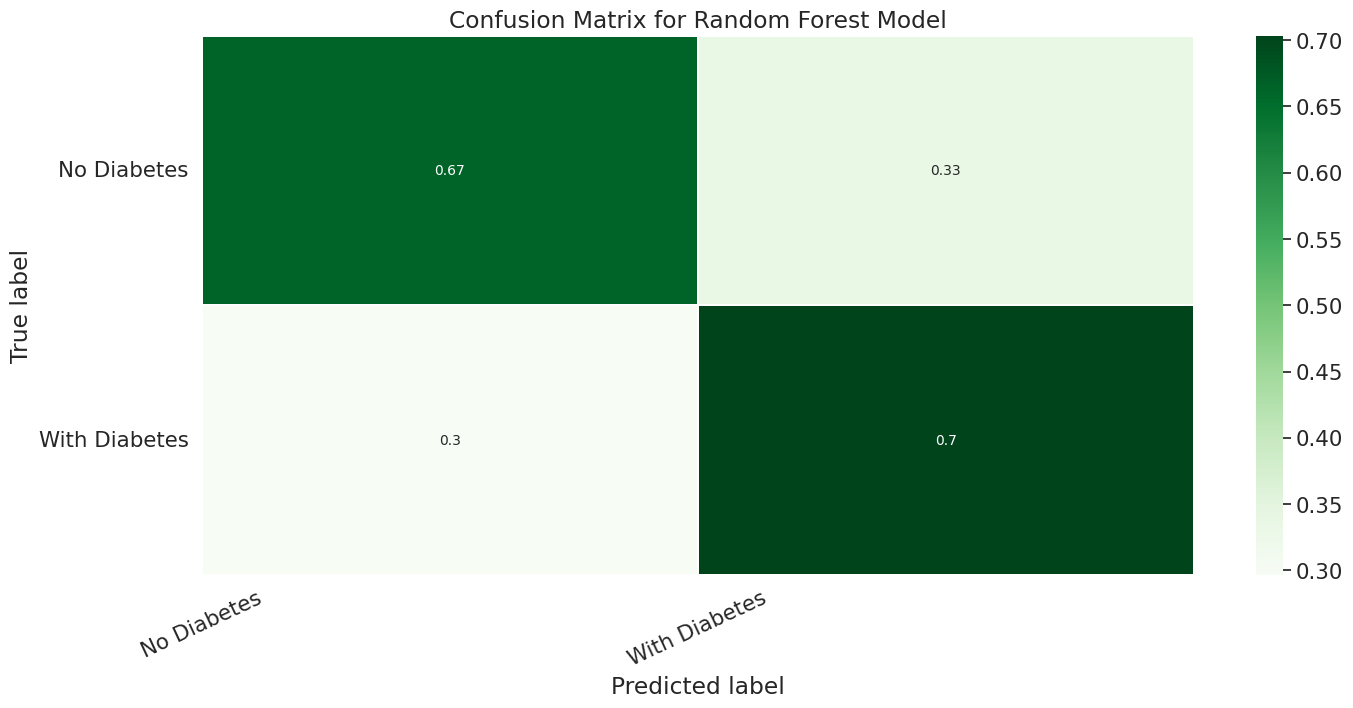

In [85]:
# make predictions on the test set
pred_bal18 = rf_bal18.predict(X_test_18)

# print the confusion matrix using Seaborn heatmap()
# Get and reshape confusion matrix data
m_bal18 = confusion_matrix(y_test_18, pred_bal18)
m_bal18 = m_bal18.astype('float') / m_bal18.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(m_bal18, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['No Diabetes', 'With Diabetes']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

## 18var class balancing

In [86]:
# trying with just setting class_weight='balanced'

rf_18_cwbal = RandomForestClassifier(class_weight='balanced')
rf_18_cwbal.fit(X_train_18, y_train_18)

RandomForestClassifier(class_weight='balanced')

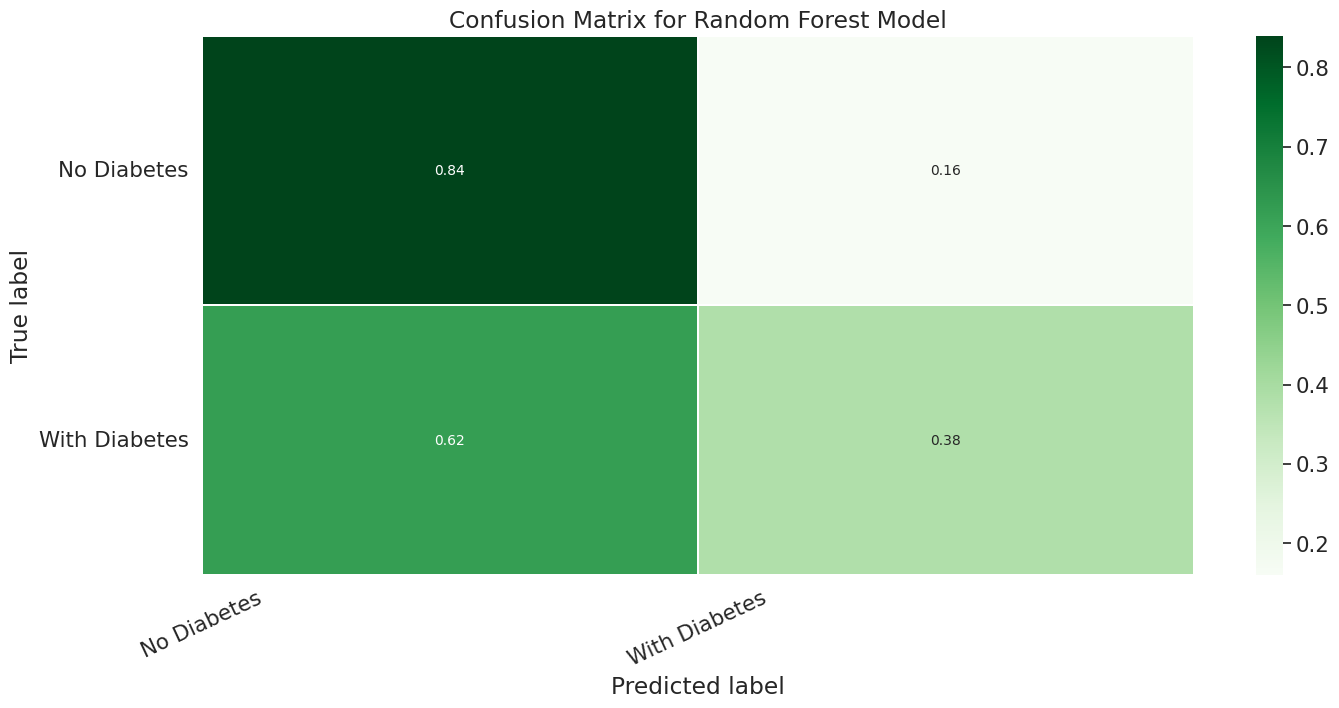

In [87]:
# make predictions on the test set
pred_18_cwbal = rf_18_cwbal.predict(X_test_18)

# print the confusion matrix using Seaborn heatmap()
# Get and reshape confusion matrix data
m_18_cwbal = confusion_matrix(y_test_18, pred_18_cwbal)
m_18_cwbal = m_18_cwbal.astype('float') / m_18_cwbal.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(m_18_cwbal, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [88]:
print(classification_report(y_test_18,pred_18_cwbal))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85     47798
           1       0.33      0.38      0.35      9715

    accuracy                           0.76     57513
   macro avg       0.60      0.61      0.60     57513
weighted avg       0.78      0.76      0.77     57513



In [89]:
# trying with Balanced RF, using base first

brf_18 = BalancedRandomForestClassifier()
brf_18.fit(X_train_18, y_train_18)

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


BalancedRandomForestClassifier()

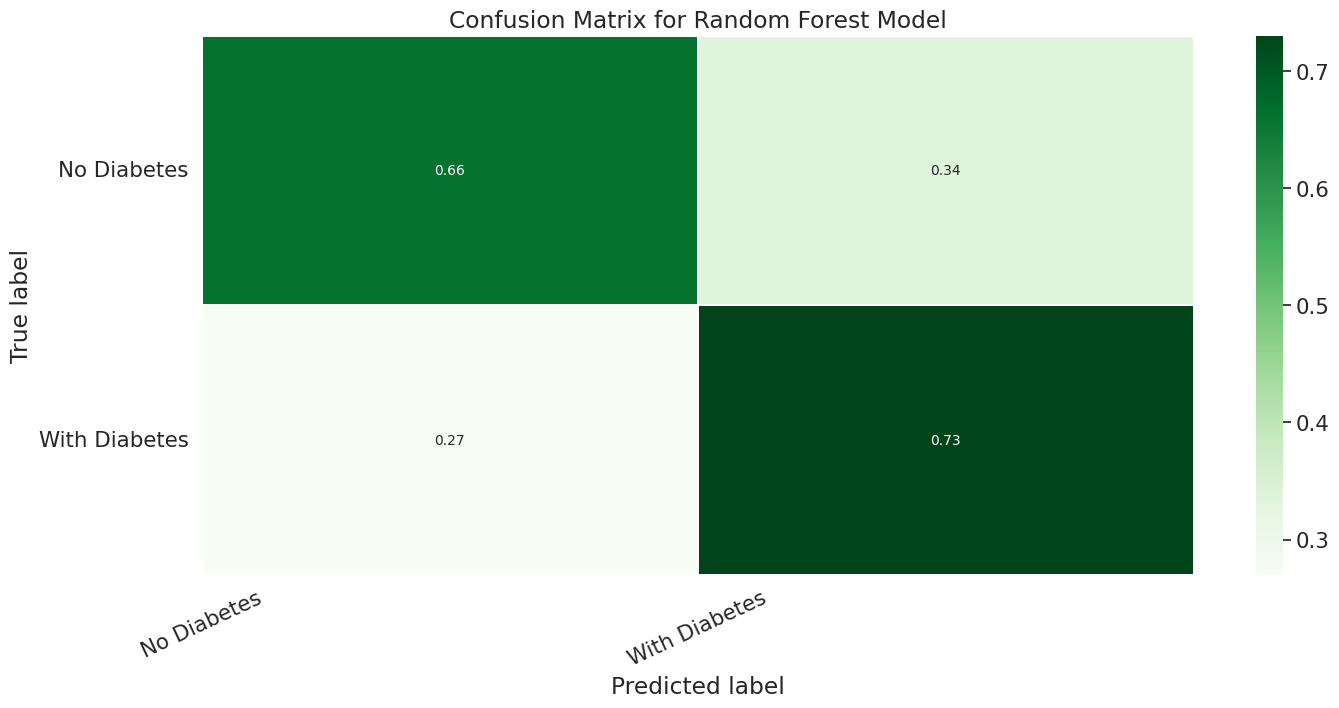

In [90]:
# make predictions on the test set
bpred_18 = brf_18.predict(X_test_18)

# print the confusion matrix using Seaborn heatmap()
# Get and reshape confusion matrix data
bm_18 = confusion_matrix(y_test_18, bpred_18)
bm_18 = bm_18.astype('float') / bm_18.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(bm_18, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [91]:
print(classification_report(y_test_18,bpred_18))

              precision    recall  f1-score   support

           0       0.92      0.66      0.77     47798
           1       0.31      0.73      0.43      9715

    accuracy                           0.67     57513
   macro avg       0.61      0.70      0.60     57513
weighted avg       0.82      0.67      0.71     57513



In [92]:
# trying with Balanced RF + class_weight='balanced'

brf_18_cw = BalancedRandomForestClassifier(class_weight='balanced')
brf_18_cw.fit(X_train_18, y_train_18)

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


BalancedRandomForestClassifier(class_weight='balanced')

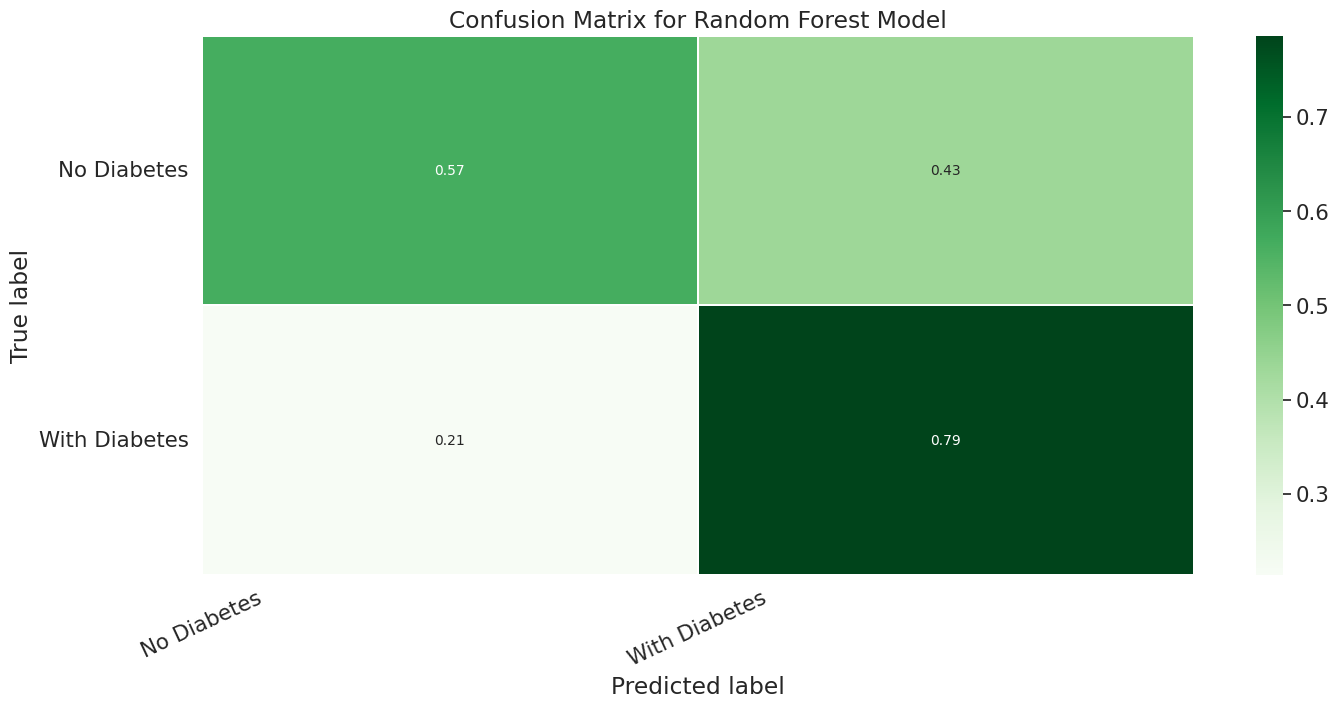

In [93]:
# make predictions on the test set
bpred_18_cw = brf_18_cw.predict(X_test_18)

# print the confusion matrix using Seaborn heatmap()
# Get and reshape confusion matrix data
bm_18_cw = confusion_matrix(y_test_18, bpred_18_cw)
bm_18_cw = bm_18_cw.astype('float') / bm_18_cw.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(bm_18_cw, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [94]:
print(classification_report(y_test_18,bpred_18_cw))

              precision    recall  f1-score   support

           0       0.93      0.57      0.70     47798
           1       0.27      0.79      0.40      9715

    accuracy                           0.60     57513
   macro avg       0.60      0.68      0.55     57513
weighted avg       0.82      0.60      0.65     57513



# 11var

In [95]:
df_11 = pd.read_csv('https://raw.githubusercontent.com/flinksey/CDC_BRFSS/refs/heads/main/2023-brfss-11var.csv')
df_11.head()

,Had_Stroke,GenHealth,PhysHealth,Exercise150,Hi_BP,Hi_Cholesterol,Chronic_Heart,Age,Hi_BMI,Education,Income,Diabetes
0,0,0,1,1,1,0,0,6,1,3,5,1
1,0,1,0,0,1,1,0,6,1,3,4,0
2,0,1,1,1,1,1,1,6,0,2,5,1
3,0,1,1,1,1,1,0,5,1,3,5,0
4,0,1,1,1,0,0,0,6,1,4,6,0


In [96]:
# split the features and the target
y_11 = df_11['Diabetes']
X_11 = df_11.drop('Diabetes', axis=1) # keep all columns except that of the target, Diabetes

# split the features and target into the train and test datasets
X_train_11, X_test_11, y_train_11, y_test_11 = train_test_split(X_11, y_11, random_state=24, stratify=y_11) # random_state to ensure reproducibility, stratify to ensure we have same proportion of the class in the split vs original dataset

In [97]:
# create instance of the base generic RF
# just want to create basis model so I'll keep the default values
rf_11 = RandomForestClassifier(random_state=11)
rf_11.fit(X_train_11, y_train_11) # fit the base model

RandomForestClassifier(random_state=11)

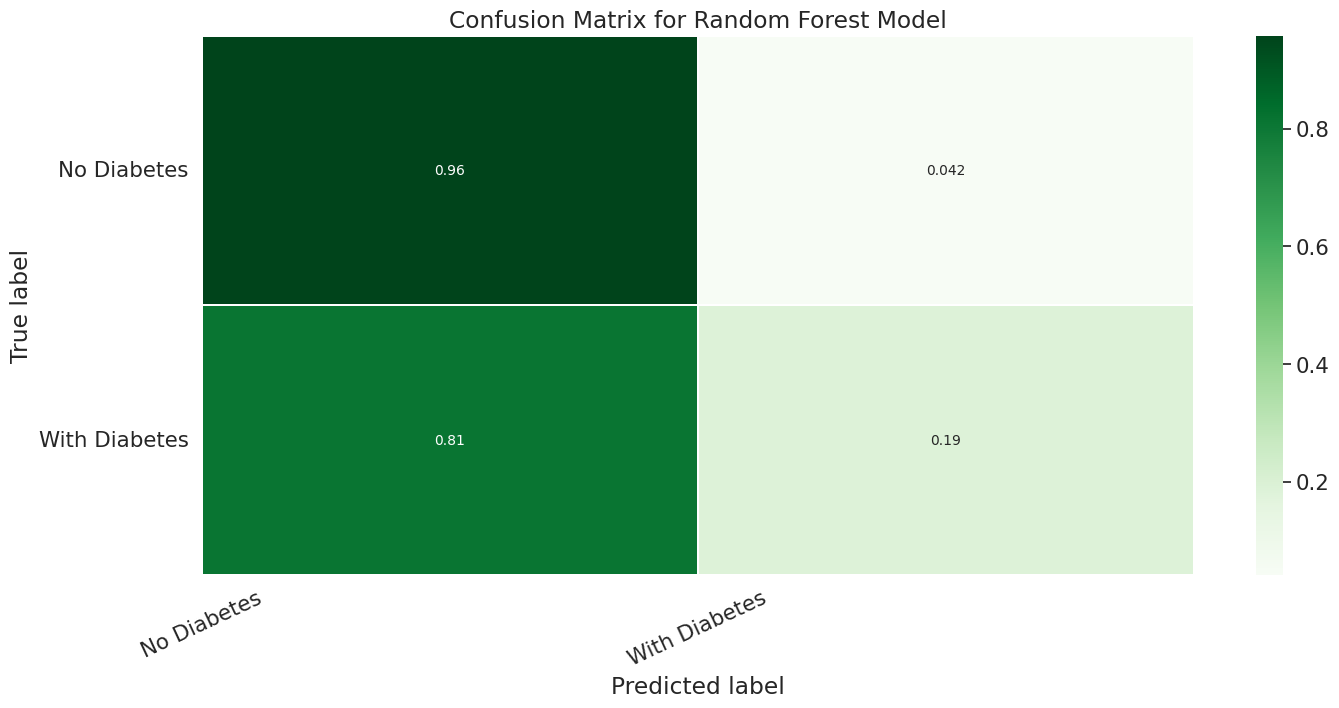

In [98]:
# make predictions on the test set
pred_11 = rf_11.predict(X_test_11)

# print the confusion matrix using Seaborn heatmap()
# Get and reshape confusion matrix data
m_11 = confusion_matrix(y_test_11, pred_11)
m_11 = m_11.astype('float') / m_11.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(m_11, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

Downsampling + class_weight='balanced'

In [99]:
# downsampling
# our majority class here is class 0
X_d11, y_d11 = resample(X_train_11[y_train_11 == 0],
                      y_train_11[y_train_11 == 0],
                      replace=False, # no need to sample with replacement because we do have at least 100k majority case samples
                      n_samples=np.sum(y_train_11 == 1), # we sample majority class to match the number of samples in the minority class
                      random_state=24) # setting random state to make this reproducible

# Concatenate the downsampled data with the minority class data

X_balcon_11 = [X_d11, X_train_11[y_train_11 == 1]] # type DataFrame
y_balcon_11 = [y_d11, y_train_11[y_train_11 == 1]] # type Series

X_bal11 = pd.concat(X_balcon_11)
y_bal11 = pd.concat(y_balcon_11)

In [100]:
# create instance of the base generic RF
# just want to create basis model so I'll keep the default values
rf_bal11 = RandomForestClassifier(class_weight='balanced',random_state=12)
rf_bal11.fit(X_bal11, y_bal11) # fit the base model

RandomForestClassifier(class_weight='balanced', random_state=12)

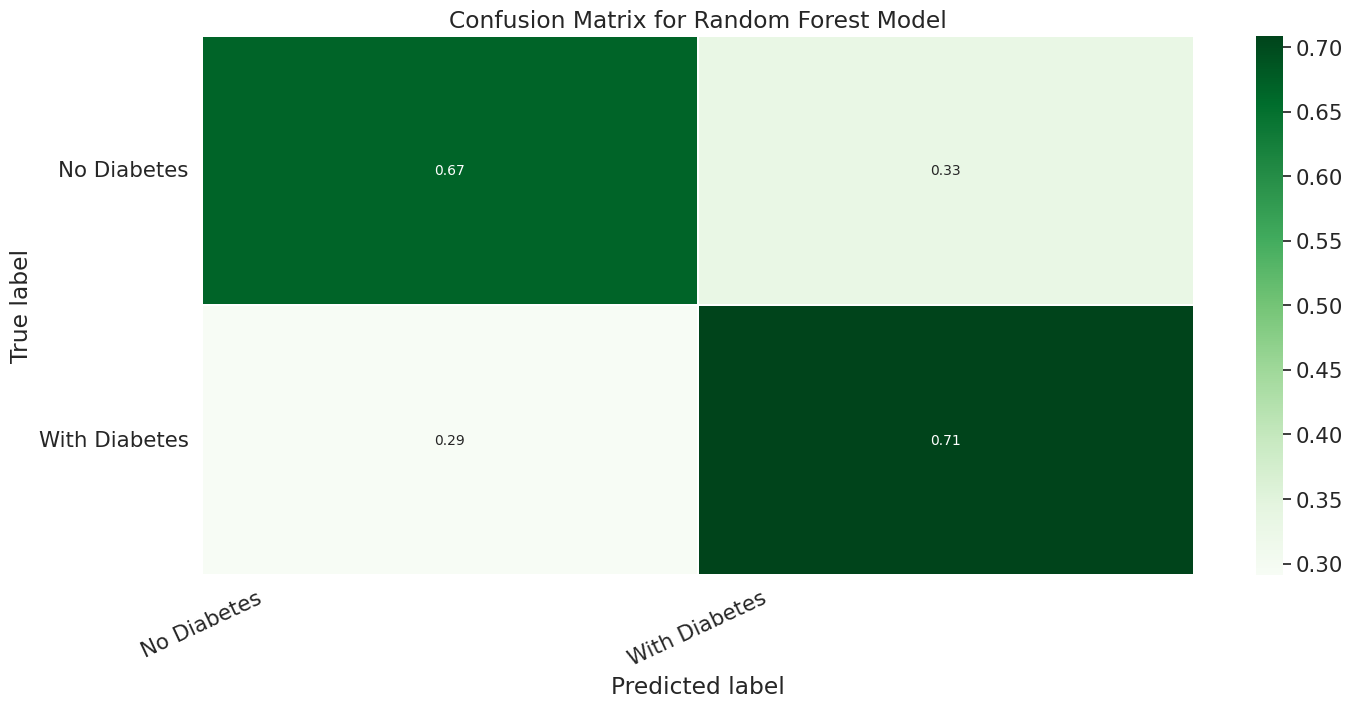

In [101]:
# make predictions on the test set
pred_bal11 = rf_bal11.predict(X_test_11)

# print the confusion matrix using Seaborn heatmap()
# Get and reshape confusion matrix data
m_bal11 = confusion_matrix(y_test_11, pred_bal11)
m_bal11 = m_bal11.astype('float') / m_bal11.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(m_bal11, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['No Diabetes', 'With Diabetes']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# 7var

In [102]:
df_7 = pd.read_csv('https://raw.githubusercontent.com/flinksey/CDC_BRFSS/refs/heads/main/Datasets/2023-brfss-7var.csv')
df_7.head()

,GenHealth,Hi_BP,Hi_Cholesterol,Chronic_Heart,Age,Hi_BMI,Income,Diabetes
0,0,1,0,0,6,1,5,1
1,1,1,1,0,6,1,4,0
2,1,1,1,1,6,0,5,1
3,1,1,1,0,5,1,5,0
4,1,0,0,0,6,1,6,0


In [103]:
# split the features and the target
y_7 = df_7['Diabetes']
X_7 = df_7.drop('Diabetes', axis=1) # keep all columns except that of the target, Diabetes

# split the features and target into the train and test datasets
X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(X_7, y_7, random_state=24, stratify=y_7) # random_state to ensure reproducibility, stratify to ensure we have same proportion of the class in the split vs original dataset

In [104]:
# create instance of the base generic RF
# just want to create basis model so I'll keep the default values
rf_7 = RandomForestClassifier(random_state=7)
rf_7.fit(X_train_7, y_train_7) # fit the base model

RandomForestClassifier(random_state=7)

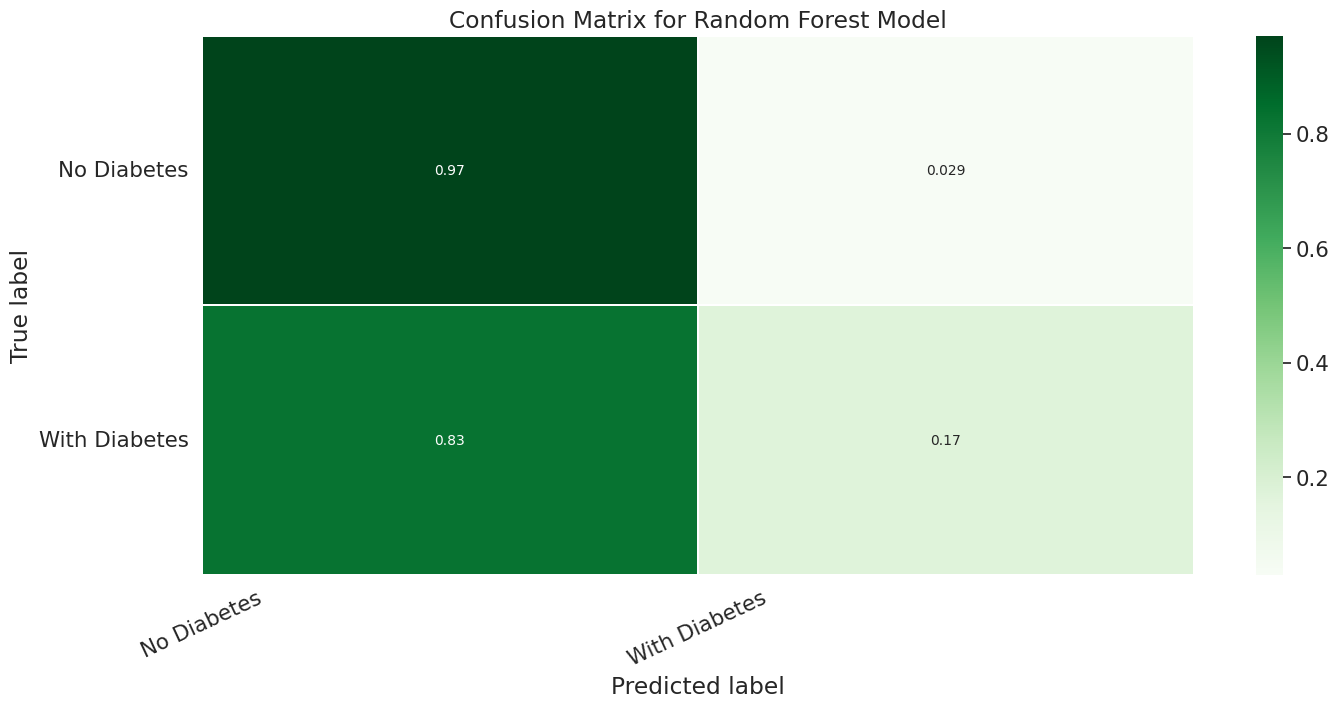

In [105]:
# make predictions on the test set
pred_7 = rf_7.predict(X_test_7)

# print the confusion matrix using Seaborn heatmap()
# Get and reshape confusion matrix data
m_7 = confusion_matrix(y_test_7, pred_7)
m_7 = m_7.astype('float') / m_7.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(m_7, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

Downsampling + class_weight='balanced'

In [106]:
# downsampling
# our majority class here is class 0
X_d7, y_d7 = resample(X_train_7[y_train_7 == 0],
                      y_train_7[y_train_7 == 0],
                      replace=False, # no need to sample with replacement because we do have at least 100k majority case samples
                      n_samples=np.sum(y_train_7 == 1), # we sample majority class to match the number of samples in the minority class
                      random_state=24) # setting random state to make this reproducible

# Concatenate the downsampled data with the minority class data

X_balcon_7 = [X_d7, X_train_7[y_train_7 == 1]] # type DataFrame
y_balcon_7 = [y_d7, y_train_7[y_train_7 == 1]] # type Series

X_bal7 = pd.concat(X_balcon_7)
y_bal7 = pd.concat(y_balcon_7)

In [107]:
# create instance of the base generic RF
# just want to create basis model so I'll keep the default values
rf_bal7 = RandomForestClassifier(class_weight='balanced',random_state=8)
rf_bal7.fit(X_bal7, y_bal7) # fit the base model

RandomForestClassifier(class_weight='balanced', random_state=8)

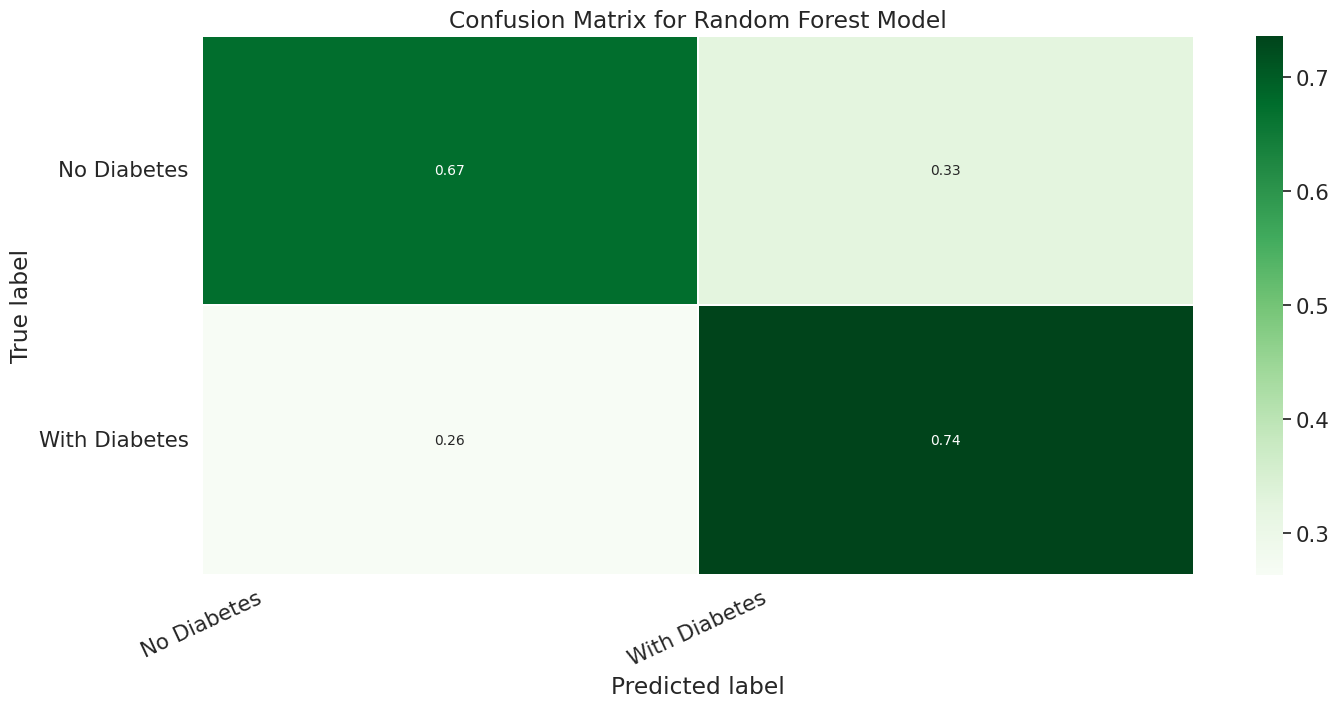

In [108]:
# make predictions on the test set
pred_bal7 = rf_bal7.predict(X_test_7)

# print the confusion matrix using Seaborn heatmap()
# Get and reshape confusion matrix data
m_bal7 = confusion_matrix(y_test_7, pred_bal7)
m_bal7 = m_bal7.astype('float') / m_bal7.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(m_bal7, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['No Diabetes', 'With Diabetes']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [109]:
print(classification_report(y_test_18,pred_bal7))

              precision    recall  f1-score   support

           0       0.93      0.67      0.78     47798
           1       0.31      0.74      0.44      9715

    accuracy                           0.68     57513
   macro avg       0.62      0.70      0.61     57513
weighted avg       0.82      0.68      0.72     57513



# Balanced RF

## 18var Bal RF

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


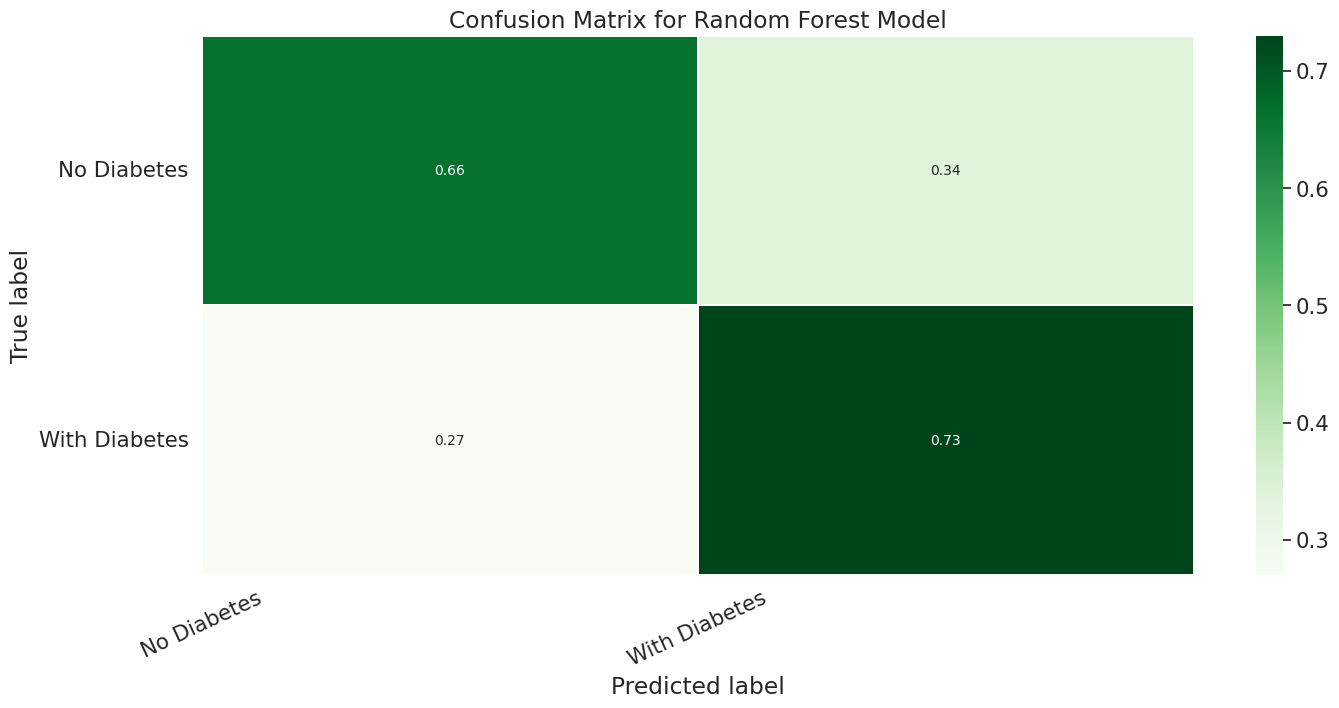

In [110]:
# create instance of the base generic RF
# just want to create basis model so I'll keep the default values
brf_18 = BalancedRandomForestClassifier(random_state=20)
brf_18.fit(X_train_18, y_train_18) # fit the base model

# make predictions on the test set
bpred_18 = brf_18.predict(X_test_18)

# print the confusion matrix using Seaborn heatmap()
# Get and reshape confusion matrix data
bm_18 = confusion_matrix(y_test_18, bpred_18)
bm_18 = bm_18.astype('float') / bm_18.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(bm_18, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['No Diabetes', 'With Diabetes']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

18var BRF with downsampled dataset

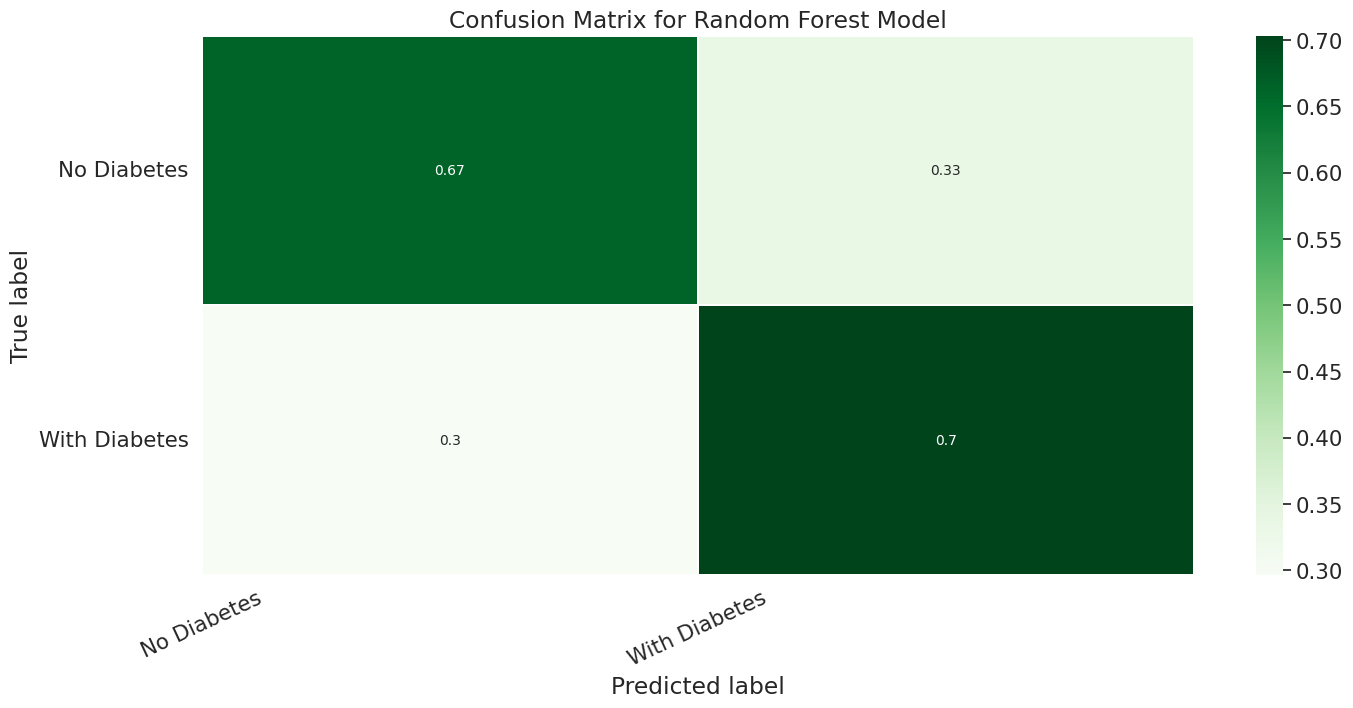

In [111]:
# create instance of the base generic RF
# just want to create basis model so I'll keep the default values
brf_bal18 = RandomForestClassifier(class_weight='balanced',random_state=21)
brf_bal18.fit(X_bal18, y_bal18) # fit the base model

# make predictions on the test set
bpred_bal18 = brf_bal18.predict(X_test_18)

# print the confusion matrix using Seaborn heatmap()
# Get and reshape confusion matrix data
bm_bal18 = confusion_matrix(y_test_18, pred_bal18)
bm_bal18 = bm_bal18.astype('float') / bm_bal18.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(bm_bal18, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['No Diabetes', 'With Diabetes']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

## 11var BRF

Base

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


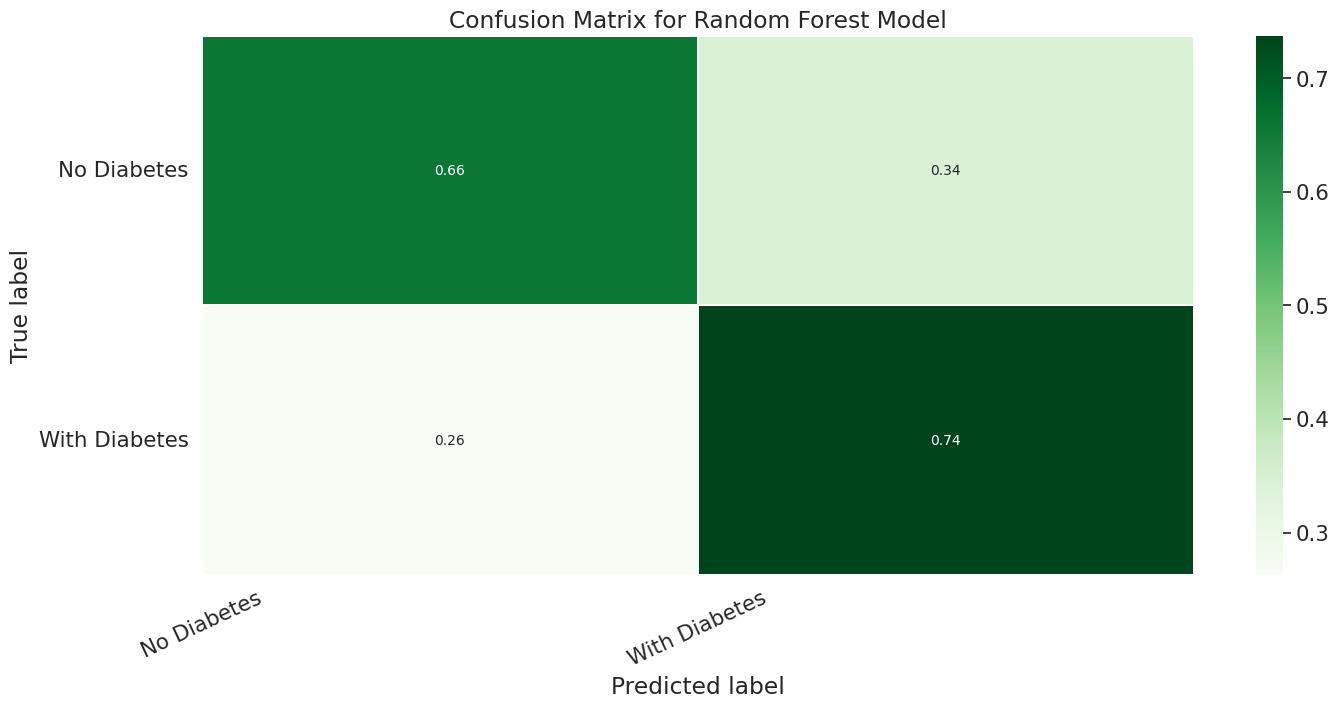

In [112]:
# create instance of the base generic RF
# just want to create basis model so I'll keep the default values
brf_11 = BalancedRandomForestClassifier(random_state=13)
brf_11.fit(X_train_11, y_train_11) # fit the base model

# make predictions on the test set
bpred_11 = brf_11.predict(X_test_11)

# print the confusion matrix using Seaborn heatmap()
# Get and reshape confusion matrix data
bm_11 = confusion_matrix(y_test_11, bpred_11)
bm_11 = bm_11.astype('float') / bm_11.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(bm_11, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['No Diabetes', 'With Diabetes']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

After downsampling

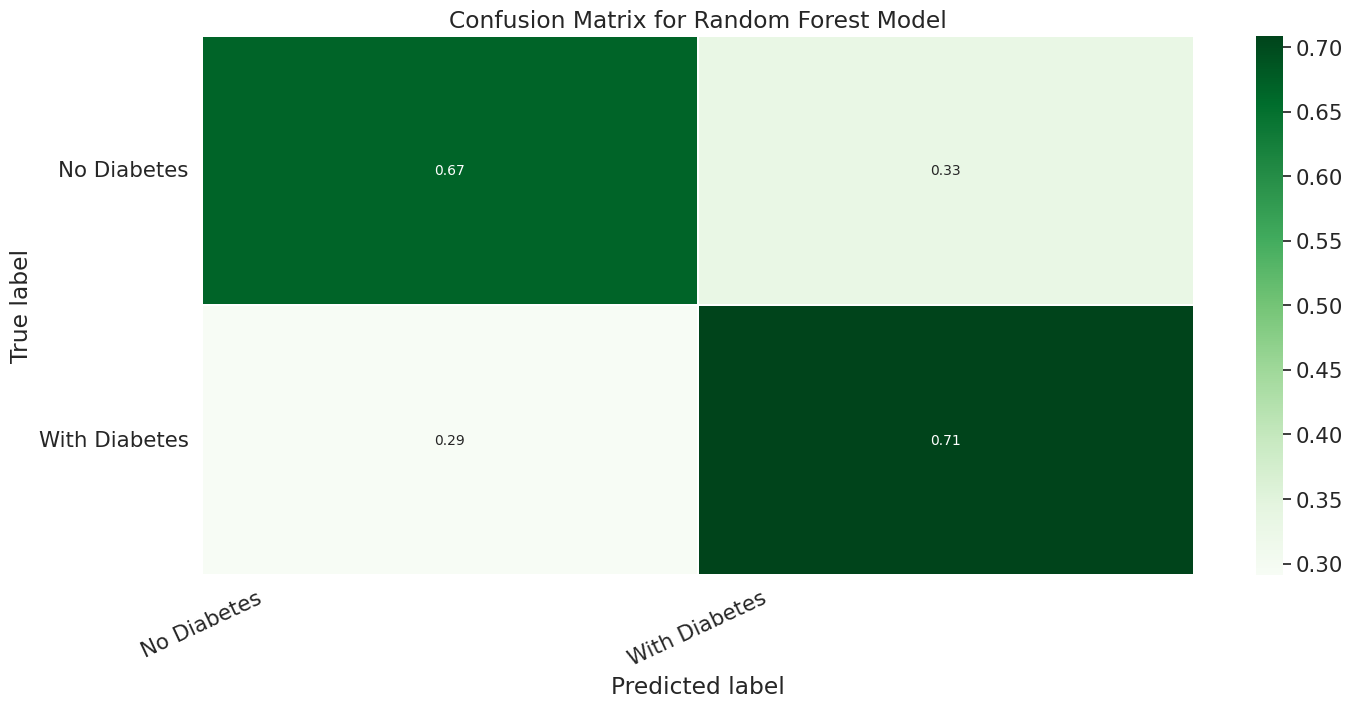

In [113]:
# create instance of the base generic RF
# just want to create basis model so I'll keep the default values
brf_bal11 = RandomForestClassifier(class_weight='balanced',random_state=14)
brf_bal11.fit(X_bal11, y_bal11) # fit the base model

# make predictions on the test set
bpred_bal11 = brf_bal11.predict(X_test_11)

# print the confusion matrix using Seaborn heatmap()
# Get and reshape confusion matrix data
bm_bal11 = confusion_matrix(y_test_11, pred_bal11)
bm_bal11 = bm_bal11.astype('float') / bm_bal11.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(bm_bal11, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['No Diabetes', 'With Diabetes']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

## 7var BRF

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


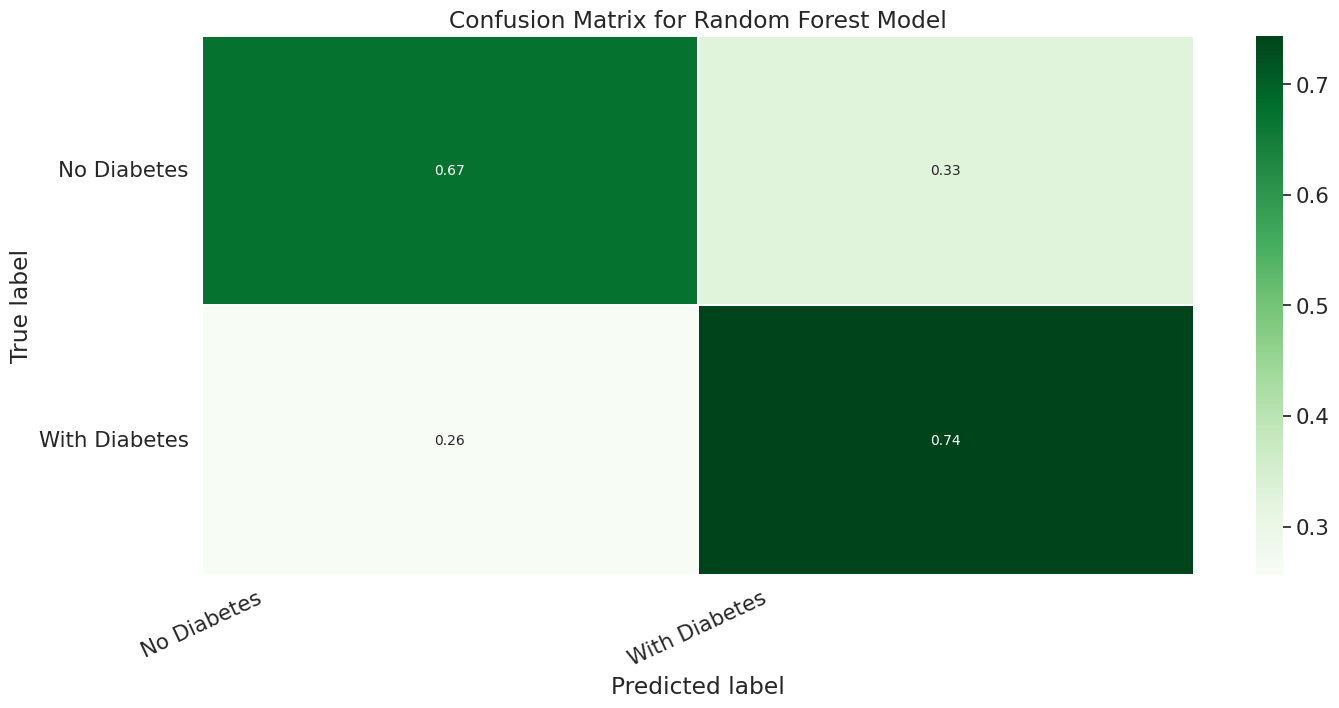

In [114]:
# create instance of the base generic RF
# just want to create basis model so I'll keep the default values
brf_7 = BalancedRandomForestClassifier(random_state=9)
brf_7.fit(X_train_7, y_train_7) # fit the base model

# make predictions on the test set
bpred_7 = brf_7.predict(X_test_7)

# print the confusion matrix using Seaborn heatmap()
# Get and reshape confusion matrix data
bm_7 = confusion_matrix(y_test_7, bpred_7)
bm_7 = bm_7.astype('float') / bm_7.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(bm_7, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['No Diabetes', 'With Diabetes']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

After downsampling

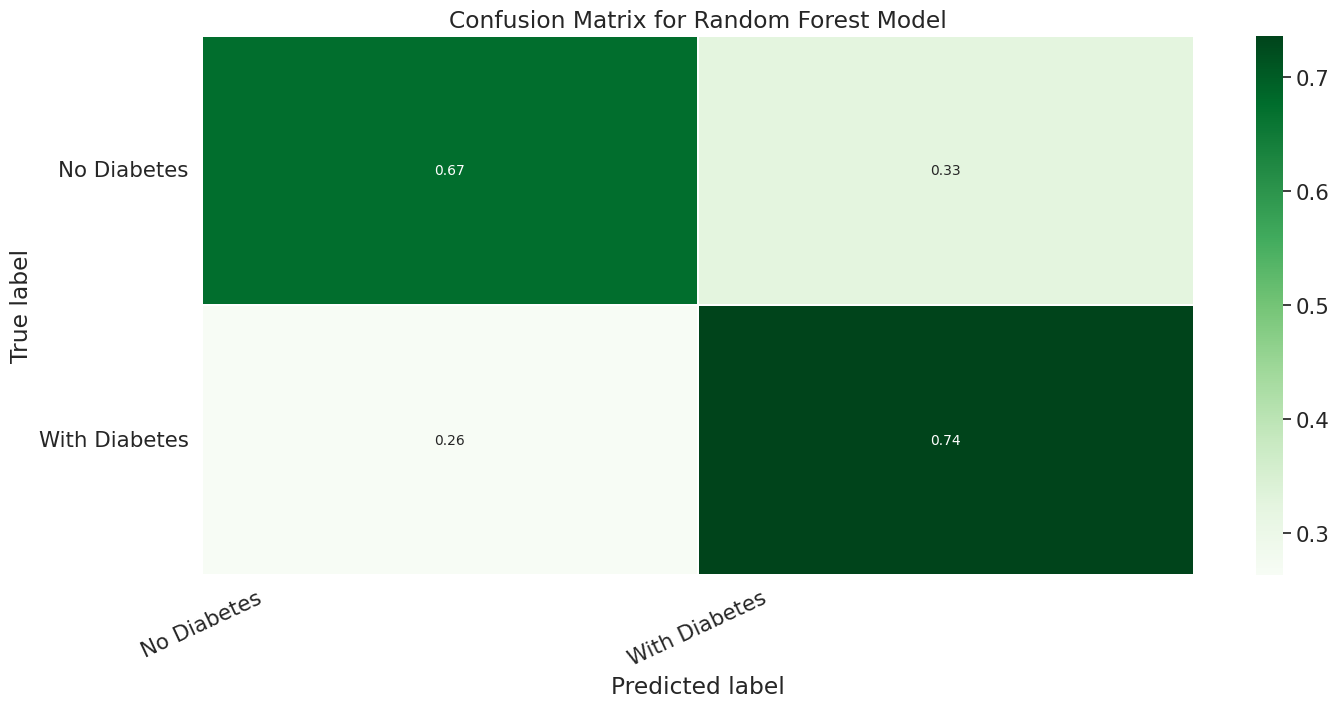

In [115]:
# create instance of the base generic RF
# just want to create basis model so I'll keep the default values
brf_bal7 = RandomForestClassifier(class_weight='balanced',random_state=10)
brf_bal7.fit(X_bal7, y_bal7) # fit the base model

# make predictions on the test set
bpred_bal7 = brf_bal7.predict(X_test_7)

# print the confusion matrix using Seaborn heatmap()
# Get and reshape confusion matrix data
bm_bal7 = confusion_matrix(y_test_7, pred_bal7)
bm_bal7 = bm_bal7.astype('float') / bm_bal7.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(bm_bal7, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['No Diabetes', 'With Diabetes']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# Comparison across downsampled + class_weight='balanced'

In [116]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc, recall_score

RF

In [120]:
# 18
predp_18 = rf_18.predict_proba(X_test_18)
base18_probs = predp_18[:,1]
precision_base18, recall_base18, _ = precision_recall_curve(y_test_18, base18_probs)
prc_base18 = auc(recall_base18, precision_base18)
print('18var Base RF Recall: %.3f' % recall_score(y_test_18,pred_18))
print('18var Base RF PR AUC: %.3f' % prc_base18)

predp_bal18 = rf_bal18.predict_proba(X_test_18)
bal18_probs = predp_bal18[:,1]
precision_18, recall_18, _ = precision_recall_curve(y_test_18, bal18_probs)
prc_bal18 = auc(recall_18, recall_18)
print('18var RF Recall: %.3f' % recall_score(y_test_18,pred_bal18))
print('18var RF PR AUC: %.3f' % prc_bal18,"\n")


# 11
predp_11 = rf_11.predict_proba(X_test_11)
base11_probs = predp_11[:,1]
precision_base11, recall_base11, _ = precision_recall_curve(y_test_11, base11_probs)
prc_base11 = auc(recall_base11, precision_base11)
print('11var Base RF Recall: %.3f' % recall_score(y_test_11,pred_11))
print('11var Base RF PR AUC: %.3f' % prc_base11)

predp_bal11 = rf_bal11.predict_proba(X_test_11)
bal11_probs = predp_bal11[:,1]
precision_11, recall_11, _ = precision_recall_curve(y_test_11, bal11_probs)
prc_bal11 = auc(recall_11, precision_11)
print('11var RF Recall: %.3f' % recall_score(y_test_11,pred_bal11))
print('11var RF PR AUC: %.3f' % prc_bal11,"\n")


# 7
predp_7 = rf_7.predict_proba(X_test_7)
base7_probs = predp_7[:,1]
precision_base7, recall_base7, _ = precision_recall_curve(y_test_7, base7_probs)
prc_base7 = auc(recall_base7, precision_base7)
print('7var Base RF Recall: %.3f' % recall_score(y_test_7,pred_7))
print('7var Base RF PR AUC: %.3f' % prc_base7)

predp_bal7 = rf_bal7.predict_proba(X_test_7)
bal7_probs = predp_bal7[:,1]
precision_7, recall_7, _ = precision_recall_curve(y_test_7, bal7_probs)
prc_bal7 = auc(recall_7, precision_7)
print('7var RF Recall: %.3f' % recall_score(y_test_7,pred_bal7))
print('7var RF PR AUC: %.3f' % prc_bal7)

18var Base RF Recall: 0.220
18var Base RF PR AUC: 0.342
18var RF Recall: 0.703
18var RF PR AUC: 0.500 

11var Base RF Recall: 0.186
11var Base RF PR AUC: 0.362
11var RF Recall: 0.709
11var RF PR AUC: 0.355 

7var Base RF Recall: 0.172
7var Base RF PR AUC: 0.400
7var RF Recall: 0.736
7var RF PR AUC: 0.388


BRF

In [123]:
# 18
bpredp_18 = brf_18.predict_proba(X_test_18)
bbase18_probs = bpredp_18[:,1]
bprecision_base18, brecall_base18, _ = precision_recall_curve(y_test_18, bbase18_probs)
bprc_base18 = auc(recall_base18, precision_base18)
print('18var Base BRF Recall: %.3f' % recall_score(y_test_18,bpred_18))
print('18var Base BRF PR AUC: %.3f' % bprc_base18)

bpredp_bal18 = brf_bal18.predict_proba(X_test_18)
bbal18_probs = bpredp_bal18[:,1]
bprecision_18, brecall_18, _ = precision_recall_curve(y_test_18, bbal18_probs)
bprc_bal18 = auc(brecall_18, brecall_18)
print('18var BRF Recall: %.3f' % recall_score(y_test_18,bpred_bal18))
print('18var BRF PR AUC: %.3f' % bprc_bal18,"\n")


# 11
bpredp_11 = brf_11.predict_proba(X_test_11)
bbase11_probs = bpredp_11[:,1]
bprecision_base11, brecall_base11, _ = precision_recall_curve(y_test_11, bbase11_probs)
bprc_base11 = auc(brecall_base11, bprecision_base11)
print('11var Base BRF Recall: %.3f' % recall_score(y_test_11,bpred_11))
print('11var Base BRF PR AUC: %.3f' % bprc_base11)

bpredp_bal11 = brf_bal11.predict_proba(X_test_11)
bbal11_probs = bpredp_bal11[:,1]
bprecision_11, brecall_11, _ = precision_recall_curve(y_test_11, bbal11_probs)
bprc_bal11 = auc(brecall_11, bprecision_11)
print('11var BRF Recall: %.3f' % recall_score(y_test_11,bpred_bal11))
print('11var BRF PR AUC: %.3f' % bprc_bal11,"\n")


# 7
bpredp_7 = brf_7.predict_proba(X_test_7)
bbase7_probs = bpredp_7[:,1]
bprecision_base7, brecall_base7, _ = precision_recall_curve(y_test_7, bbase7_probs)
bprc_base7 = auc(brecall_base7, bprecision_base7)
print('7var Base BRF Recall: %.3f' % recall_score(y_test_7,bpred_7))
print('7var Base BRF PR AUC: %.3f' % bprc_base7)

bpredp_bal7 = rf_bal7.predict_proba(X_test_7)
bbal7_probs = predp_bal7[:,1]
bprecision_7, brecall_7, _ = precision_recall_curve(y_test_7, bbal7_probs)
bprc_bal7 = auc(brecall_7, bprecision_7)
print('7var BRF Recall: %.3f' % recall_score(y_test_7,bpred_bal7))
print('7var BRF PR AUC: %.3f' % bprc_bal7)

18var Base BRF Recall: 0.730
18var Base BRF PR AUC: 0.342
18var BRF Recall: 0.703
18var BRF PR AUC: 0.500 

11var Base BRF Recall: 0.737
11var Base BRF PR AUC: 0.373
11var BRF Recall: 0.712
11var BRF PR AUC: 0.356 

7var Base BRF Recall: 0.744
7var Base BRF PR AUC: 0.399
7var BRF Recall: 0.736
7var BRF PR AUC: 0.388
